# Neural Network from Scratch

In this lab we'll create a neural network from scratch. In the process we'll learn about the algorithm that makes it all possible, **backpropagation**. In the end we'll end up with a mini Tensorflow-like library.

Outline:
1. Intro to Backprop + chain rule, derivatives of (+, * , -) topped with a simple example
2. Transition to thinking about functions as nodes with inputs and outputs in a graph. Rewrite previous example in these terms.
3. Matrix/vector, sigmoid ops + derivatives. MSE or Cross-entropy depending on if we’re regressing or classifying. 
4. Create neural net + train with SGD (MNIST?)


## Backpropagation and the Chain Rule

TODO: Improve this intro

The fundamental idea behind neural networks is to minimize an objective, typically known as the *loss function*. The loss function outputs a single number that tells us how well we're doing, the smaller the better.

We can think of a neural network as a composition of functions with a loss (number) as the output.

$$L = f_n(f_{n-1}(...f_1(x)...))$$

The idea behind backpropagation, also known as reverse-mode differentiation is to use the chain rule

$$
\frac{\partial L}{\partial f_n}
\frac{\partial f_n}{\partial f_{n-1}}
...
\frac{\partial f_1}{\partial f_x}
$$

#### TODO: transition from above abstract functions to things like multplication and addition



$$
f = * \hspace{0.5in} f(x,y) = xy
$$

$$
\frac{\partial f}{\partial x} = y \hspace{0.5in} \frac{\partial f}{\partial y} = x
$$

Let's think about this for a bit. What we're saying here is the change of $f$ with respect to $x$ is $y$ and vice-versa. Remember, if our derivative is with respect to $x$ we treat $y$ as a constant. So let's say $y = 10$, think about changing $x$ from 3 to 4. Then $f(3,10) = 30$ and $f(4, 10) = 40$. That's a change in 10 or $y$! Every time we change $x$ by 1, $f$ changes by $y$.


$$
f = + \hspace{0.5in} f(x,y) = x + y
$$

$$
\frac{\partial f}{\partial x} = 1 \hspace{0.5in} \frac{\partial f}{\partial y} = 1
$$

Again, let's think about this. The change in $f$ with respect to $x$ is 1 and same for $y$. This means every time we change $x$ by 1, $f$ will also change by 1. This also shows $x$ and $y$ are independent of eachother.

$$
f = - \hspace{0.5in} f(x) = -x
$$

$$
\frac{\partial f}{\partial x} = -1
$$

The change in $f$ with respect to $x$ is -1. We can easily see this by plugging in some values f(3) = -3, f(10) = -10. A change in $x$ by 7 results in a change in $f(x)$ by -7.

Ok, let's now use this for a simple function.

TODO: picture here

In [ ]:
# f(x, y, z) = x * y + -z
# we can split these into subexpressions
# g(x,y) = x * y
# h(z) = -z
# f(x, y, z) = g(x, y) + h(z)

# intial values
x = 3
y = 4
z = 5

g = x * y
h = -z

f = g + h
print(f)

Let's take our function $f$ and apply the chain rule to compute the derivatives for $x, y, z$.

$$
\frac{\partial f}{\partial g} = 1 \hspace{0.1in}
\frac{\partial g}{\partial x} = y \hspace{0.1in}
\frac{\partial g}{\partial y} = x \hspace{0.1in}
\frac{\partial f}{\partial h} = 1 \hspace{0.1in}
\frac{\partial h}{\partial z} = -1
$$


$$
\frac{\partial f}{\partial x} = 
\frac{\partial f}{\partial g}
\frac{\partial g}{\partial x}
\hspace{0.5in}
\frac{\partial f}{\partial y} = 
\frac{\partial f}{\partial g}
\frac{\partial g}{\partial y}
\hspace{0.5in}
\frac{\partial f}{\partial z} = 
\frac{\partial f}{\partial h}
\frac{\partial h}{\partial z}
$$


$$
\frac{\partial f}{\partial x} = 1 * y = y
\hspace{0.5in}
\frac{\partial f}{\partial y} = 1 * x = x
\hspace{0.5in}
\frac{\partial f}{\partial z} = 1 * -1 = -1
$$

In [ ]:
# in code 
dfdg = 1.0
dfdh = 1.0
dgdx = y
dgdy = x
dhdz = -1.0

dfdx = dfdg * dgdx
dfdy = dfdg * dgdy
dfdz = dfdh * dhdz

# the output of backpropagation is the gradient
gradient = [dfdx, dfdy, dfdz]
print(gradient)

## Graphs, Nodes and Ops

Goals of this section

1. rephrase the above in terms of graphs and nodes. A node consists of inputs, outputs, a function and additional data (cached forward values for the backward pass).
2. Get the API for mini TF down.
3. Rewrite above sample using mini Tf.

I'd like to draw attention to a few things from the previous section.

1. The picture of the broken down expression and subexpressions of $f$ resembles a graph where the nodes are function applications.
2. We can use of dynamic programming to make computing backpropagation efficient. Even in our simple example we see the reuse of $\frac{\partial f}{\partial g}$ when computing $\frac{\partial f}{\partial x}$ and $\frac{\partial f}{\partial y}$. As our graph grows in size and complexity, it becomes much more evident how wasteful it is to recompute partials. The cornerstone of dynamic programming is **solving a large problem through many smaller ones** and **caching**. We'll do both!

## Additional Ops + Derivates

Goals of this section

1. Derivatives for matrix/matrix matrix/vector operations along with sigmoid and (cross-entropy or mse)
2. Register these ops

## Create neural net

Goals of this section

1. Use mini TF to create a neural net and train on MNIST using SGD
2. Outro to TF

In [1]:
%load_ext autoreload
%autoreload 2
from miniflow import *
import matplotlib.pyplot as plt
%matplotlib inline

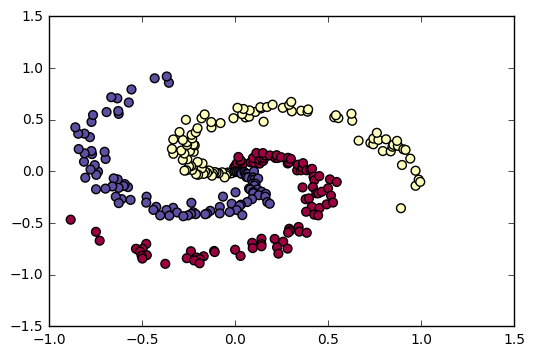

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

In [3]:
X_in, W_in, b_in, y_in = Input(), Input(), Input(), Input()
f = Linear(X_in, W_in, b_in)
f = CrossEntropyLoss(f, y_in)

In [4]:
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

In [5]:
# works
alpha = 1e-0
for i in range(200):
    feed_dict = {X_in: X, W_in: W, b_in: b, y_in: y}
    loss, grad = loss_and_grad(f, feed_dict, [W_in, b_in])
    
    if i % 10 == 0:
        print("Iteration {}: Loss = {}".format(i, loss))
        
    # SGD
    dW, db = grad
    W -= alpha * dW
    b -= alpha * db

Iteration 0: Loss = 1.095999647975534
Iteration 10: Loss = 0.9020292026231069
Iteration 20: Loss = 0.8277282545823542
Iteration 30: Loss = 0.7928211354657058
Iteration 40: Loss = 0.7739784429211292
Iteration 50: Loss = 0.7628285386297029
Iteration 60: Loss = 0.7557993541964
Iteration 70: Loss = 0.7511612131372958
Iteration 80: Loss = 0.7479947628064765
Iteration 90: Loss = 0.745775693461579
Iteration 100: Loss = 0.744188199756219
Iteration 110: Loss = 0.743033638040589
Iteration 120: Loss = 0.7421826047471177
Iteration 130: Loss = 0.7415483427285658
Iteration 140: Loss = 0.741071280738785
Iteration 150: Loss = 0.7407096869593226
Iteration 160: Loss = 0.7404338275598185
Iteration 170: Loss = 0.740222209935723
Iteration 180: Loss = 0.7400591060037827
Iteration 190: Loss = 0.7399328837007403
